In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.12.0


In [2]:
batch_size = 128
epochs = 12
image_size = (300,300)
test_size = 0.2

# Load Data and division of Data
Total validation images = 16

Total training images = 5216

There is lot of training images compare to validation images and division between these two dataset not in 80:20 ratio.

In below cell, divsion of 80:20 performed after merging all the validation and training images in a list of files.

In [12]:
training_images = tf.io.gfile.glob('Dataset/train/*/*')
validation_images = tf.io.gfile.glob('Dataset/val/*/*')


print(f'Before division of 80:20')
print(f'Total number of training images = {len(training_images)}')
print(f'Total number of validation images = {len(validation_images)}\n')


total_files = training_images
total_files.extend(validation_images)
print(f'Total number of images : training_images + validation_images = {len(total_files)}\n')

train_images, val_images = train_test_split(total_files, test_size = test_size)
print(f'After division of 80:20')
print(f'Total number of training images = {len(train_images)}')
print(f'Total number of validation images = {len(val_images)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 16

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


After analysing the training dataset that has been created in above cell, there is lot of Pneumonia images(positive) in comparison to Normal images(negative). This shows that imbalance in data. Correction for imbalance in data performed in Correction for Data Imbalance Section.

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


<AxesSubplot:ylabel='count'>

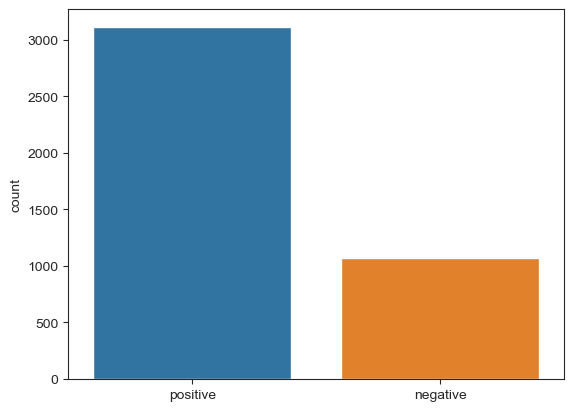

In [13]:
count_normal = len([x for x in train_images if "NORMAL" in x])
print(f'Normal images count in training set: {count_normal}')

count_pneumonia = len([x for x in train_images if "PNEUMONIA" in x])
print(f'Pneumonia images count in training set: {count_pneumonia}')

count_array = []
count_array += ['positive']*count_pneumonia
count_array += ['negative']*count_normal

sns.set_style('ticks')
sns.countplot(x=count_array)

Creating a few Directories to store the new divided data

In [14]:
tf.io.gfile.makedirs('Dataset/temp/val_dataset/negative/')
tf.io.gfile.makedirs('Dataset/temp/val_dataset/positive/')
tf.io.gfile.makedirs('Dataset/temp/train_dataset/negative/')
tf.io.gfile.makedirs('Dataset/temp/train_dataset/positive/')

Creating directory in Kaggle/working directory for training dataset and validation dataset after division of 80:20.

In both directory there is more two directory i.e. negative and positive

The directory struture is same as the structure in Input directory.

In [24]:
for ele in train_images:
    parts_of_path = ele.split('\\')
    
    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = 'Dataset/temp/train_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = 'Dataset/temp/train_dataset/negative/' +  parts_of_path[-1])

In [25]:
for ele in val_images:
    parts_of_path = ele.split('\\')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = 'Dataset/temp/val_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = 'Dataset/temp/val_dataset/negative/' +  parts_of_path[-1])

# Data Augmentation

In [27]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                 rotation_range = 30,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1)
val_datagen = ImageDataGenerator(rescale = 1/255)
                                

train_generator = train_datagen.flow_from_directory(
    'Dataset/temp/train_dataset/',
    target_size = image_size,
    batch_size = batch_size ,
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    'Dataset/temp/val_dataset/',
    target_size = image_size,
    batch_size = batch_size ,
    class_mode = 'binary'
)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.


In [28]:
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    'Dataset/test',
    target_size = image_size,
    batch_size = batch_size , 
    class_mode = 'binary'
)

Found 624 images belonging to 2 classes.


# Correction for Data Imbalance

In [29]:
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

array([1.0685705])

In [30]:
weight_for_0 = (1 / count_normal)*(len(train_images))/2.0 
weight_for_1 = (1 / count_pneumonia)*(len(train_images))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


# VGG Net Model (After Tuning)

All the below parameters are found by experimenting many times while fine-tuning the model. i.e for Dense layers, it was trained with different no. of neurons (4096, 1024, 512) but the best result found by taking 512 neurons for Dense layers and using Dropout (0.2 and 0.5 while fine-tuning) 0.2 gives us best result.

In [54]:
base_model1 = tf.keras.applications.VGG16(input_shape=(300, 300, 3),include_top=False, weights='imagenet')
base_model1.trainable = False


model1 = tf.keras.Sequential([
        base_model1,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
        ])

model1.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])
model1.summary()

58889256/58889256 [==============================] - 53s 1us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               21234176  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Below code block shows, number of layers for base model (vgg) which is 19 and out of 19 I choose to freeze all 19 layers while training it means we will not be training those 19 freezed layers.

In [55]:
print(len( base_model1.layers))

19


Below code helps us to save the best model while training and using earlystopping callbacks provided by tensorflow to keep monitoring the validation loss, and saving those model which had less validation loss while training and (patience = 20) while training for 20 more epochs if there is no improvement in validation loss, we will stop the training.

In [56]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("model1_vgg.h5",
                                                    save_best_only=True)

early_stopping_cb1 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=20, mode = 'min',restore_best_weights=True)

### Train the model

In [57]:
history1 = model1.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb1, early_stopping_cb1]
)

Epoch 1/12
10/10 [==============================] - 365s 38s/step - loss: 6.9873 - accuracy: 0.5052 - val_loss: 1.1289 - val_accuracy: 0.2808
Epoch 2/12
10/10 [==============================] - 359s 37s/step - loss: 0.6487 - accuracy: 0.6648 - val_loss: 1.3589 - val_accuracy: 0.4107
Epoch 3/12
10/10 [==============================] - 359s 37s/step - loss: 0.5549 - accuracy: 0.7461 - val_loss: 0.4154 - val_accuracy: 0.8243
Epoch 4/12
10/10 [==============================] - 358s 37s/step - loss: 0.4295 - accuracy: 0.7977 - val_loss: 0.6257 - val_accuracy: 0.7421
Epoch 5/12
10/10 [==============================] - 360s 38s/step - loss: 0.4635 - accuracy: 0.7891 - val_loss: 0.4567 - val_accuracy: 0.7899
Epoch 6/12
10/10 [==============================] - 382s 40s/step - loss: 0.2625 - accuracy: 0.8815 - val_loss: 0.2119 - val_accuracy: 0.9198
Epoch 7/12
10/10 [==============================] - 357s 37s/step - loss: 0.3410 - accuracy: 0.8523 - val_loss: 0.3189 - val_accuracy: 0.8625
Epoch 

Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

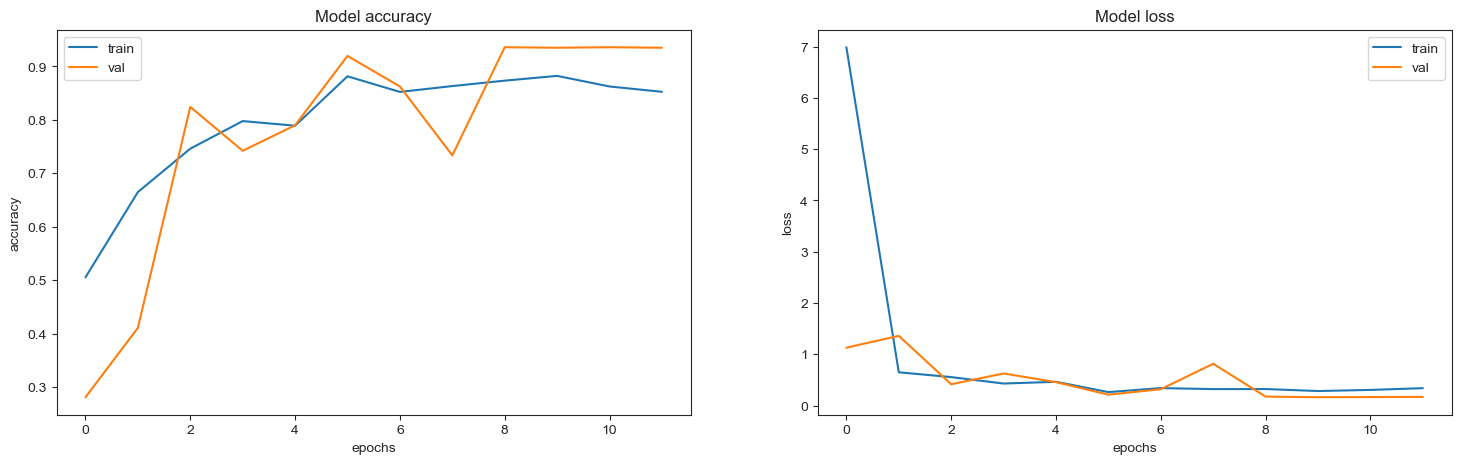

In [58]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history1.history[element])
    axis[i].plot(history1.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

### Predict and Evaluate on test dataset

In [60]:
eval_result1 = model1.evaluate(test_generator)
print('loss rate at evaluation data :', eval_result1[0])
print('accuracy rate at evaluation data :', eval_result1[1])

5/5 [==============================] - 96s 19s/step - loss: 0.3197 - accuracy: 0.8782
loss rate at evaluation data : 0.31972840428352356
accuracy rate at evaluation data : 0.8782051205635071


# Inception Net Model (After tuning)

All the below parameters are found by experimenting many times while fine-tuning the model. i.e number of the layers that should not be trained, (so 200 layers out of 311 are freezed and will not trained while training), I also tried to add Dense layers but it was not giving good results on test dataset.

In [31]:
base_model2 = tf.keras.applications.InceptionV3(input_shape=(300, 300, 3),include_top=False, weights='imagenet')

for layers in base_model2.layers[:200]:
    layers.trainable = False

model2 = tf.keras.Sequential([
        base_model2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid) 
        ])

model2.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

model2.summary()

87910968/87910968 [==============================] - 54s 1us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 14,806,337
Non-trainable params: 6,998,496
_________________________________________________________________


Below code block shows, number of layers for base model (Inception) which is 311. and out of 311 layers, I choose to freeze 200 layers while training it means we will not be training those 200 freezed layers.

In [32]:
len(base_model2.layers)

311

Below code helps us to save the best model while training and using earlystopping callbacks provided by tensorflow to keep monitoring the validation loss, and saving those model which had less validation loss while training and (patience = 20) while training for 20 more epochs if there is no improvement in validation loss, we will stop the training.

In [33]:
checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint("model1_inceptionNet.h5",
                                                    save_best_only=True)

early_stopping_cb2 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=20, mode = 'min',restore_best_weights=True)

### Train the model

In [34]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb2, early_stopping_cb2]    
)

Epoch 1/12
10/10 [==============================] - 150s 15s/step - loss: 0.4523 - accuracy: 0.8141 - val_loss: 6.5635 - val_accuracy: 0.3878
Epoch 2/12
10/10 [==============================] - 141s 14s/step - loss: 0.1261 - accuracy: 0.9508 - val_loss: 0.5252 - val_accuracy: 0.8663
Epoch 3/12
10/10 [==============================] - 141s 14s/step - loss: 0.0789 - accuracy: 0.9758 - val_loss: 0.7667 - val_accuracy: 0.8090
Epoch 4/12
10/10 [==============================] - 142s 14s/step - loss: 0.0550 - accuracy: 0.9782 - val_loss: 0.5433 - val_accuracy: 0.8835
Epoch 5/12
10/10 [==============================] - 142s 14s/step - loss: 0.0605 - accuracy: 0.9711 - val_loss: 0.8725 - val_accuracy: 0.8596
Epoch 6/12
10/10 [==============================] - 140s 14s/step - loss: 0.0505 - accuracy: 0.9774 - val_loss: 0.1580 - val_accuracy: 0.9647
Epoch 7/12
10/10 [==============================] - 143s 15s/step - loss: 0.0573 - accuracy: 0.9742 - val_loss: 0.4484 - val_accuracy: 0.9255
Epoch 

### Visualise the model performance

Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recorded at the end of every epoch

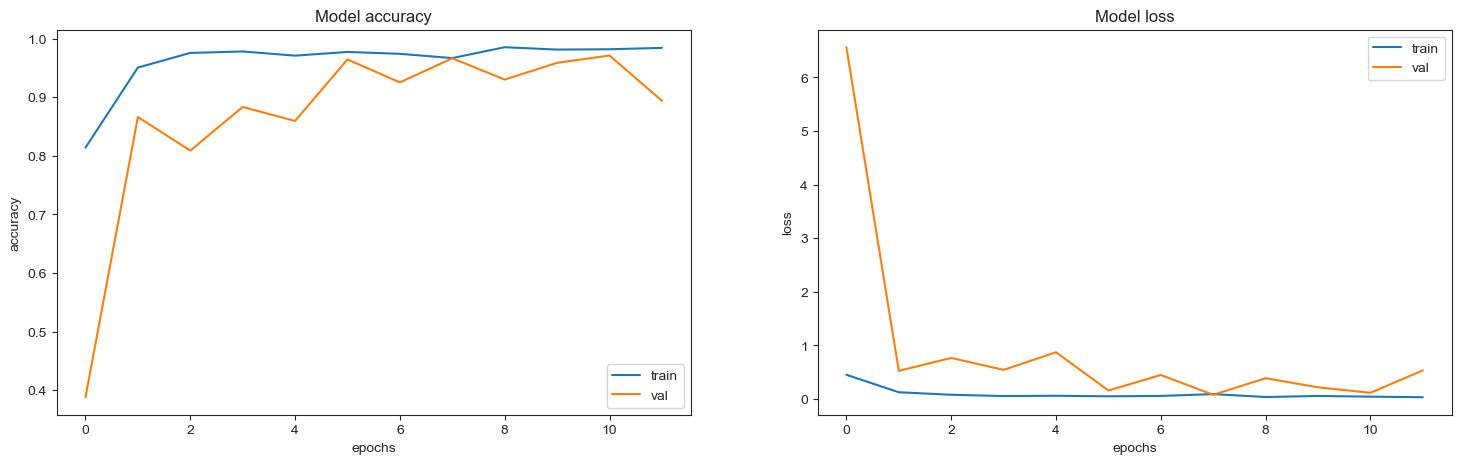

In [35]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history2.history[element])
    axis[i].plot(history2.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

### Predict and Evaluate on test dataset

In [39]:
eval_result2 = model2.evaluate(test_generator)
print('loss rate at evaluation data :', eval_result2[0])
print('accuracy rate at evaluation data :', eval_result2[1])

5/5 [==============================] - 23s 4s/step - loss: 0.4256 - accuracy: 0.9006
loss rate at evaluation data : 0.4255848526954651
accuracy rate at evaluation data : 0.9006410241127014


Below code helps us find the list of images on which prediction is wrong as well as list of images on which prediction is correct.

In [41]:
Inception_model = model2

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 128 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = Inception_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
#         print(len(correct_predicted_image[0]),len(wrong_predicted_image[0]))
        j += 1
        
    i += 1

1/1 [==============================] - 0s 68ms/step


## Images on which output predicted incorrectly by model

wrong_prediction_by_model --- [1, 1, 0, 0, 1, 1]


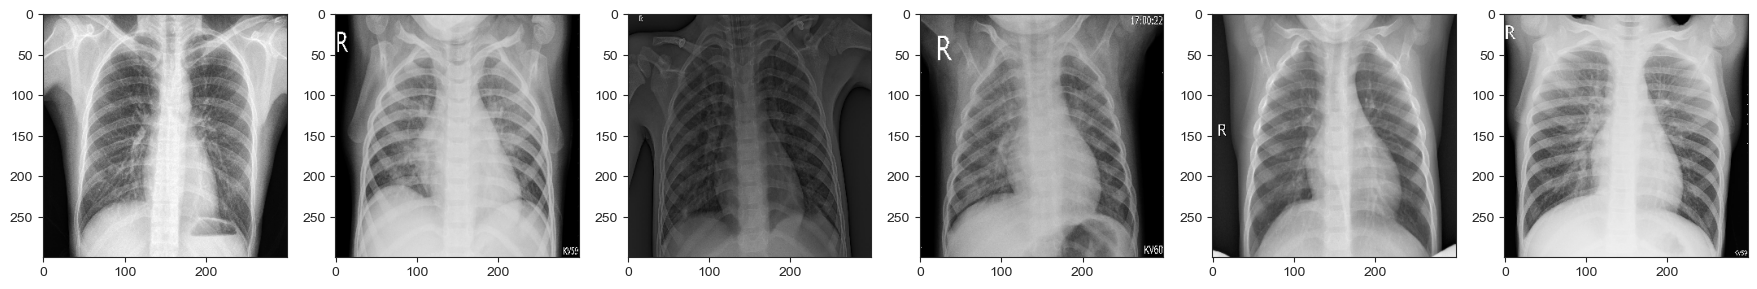

In [42]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'wrong_prediction_by_model --- {wrong_predicted_image[1]}')

## Images on which output predicted correctly by model

correct_prediction_by_model --- [1, 1, 1, 1, 0, 1]


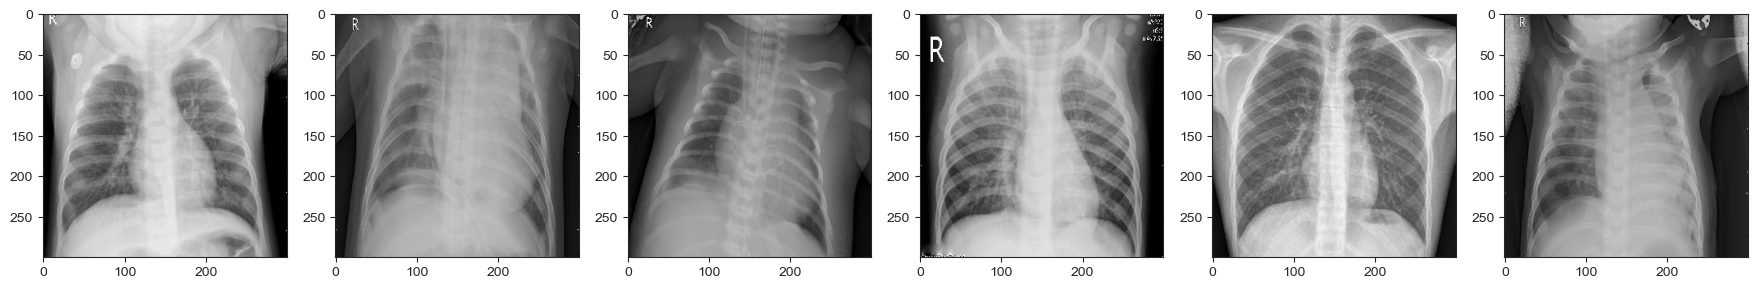

In [43]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'correct_prediction_by_model --- {correct_predicted_image[1]}')

# Residual Net Model (After tuning)

In [44]:
base_model3 = tf.keras.applications.ResNet50(input_shape=(300, 300, 3),include_top=False, weights='imagenet')
# base_model3.trainable = False
for layers in base_model3.layers[:100]:
    layers.trainable = False

model3 = tf.keras.Sequential([
        base_model3,
        tf.keras.layers.GlobalAveragePooling2D(),
#          tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(512, activation=tf.nn.relu),
#          tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(512, activation=tf.nn.relu),
#         tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid),
        ])

model3.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])
model3.summary()

94765736/94765736 [==============================] - 85s 1us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 19,454,977
Non-trainable params: 4,134,784
_________________________________________________________________


In [45]:
len(base_model3.layers)

175

Below code helps us to save the best model while training and using earlystopping callbacks provided by tensorflow to keep monitoring the validation loss, and saving those model which had less validation loss while training and (patience = 20) while training for 20 more epochs if there is no improvement in validation loss, we will stop the training.

In [46]:
checkpoint_cb3= tf.keras.callbacks.ModelCheckpoint("model3_resnet.h5",
                                                    save_best_only=True)

early_stopping_cb3 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=20, mode = 'min',restore_best_weights=True)

## Train the model

In [47]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb3, early_stopping_cb3] 
)

Epoch 1/12
10/10 [==============================] - 271s 27s/step - loss: 2.5391 - accuracy: 0.4480 - val_loss: 7.8027 - val_accuracy: 0.7335
Epoch 2/12
10/10 [==============================] - 256s 26s/step - loss: 0.8371 - accuracy: 0.5858 - val_loss: 82.6588 - val_accuracy: 0.7335
Epoch 3/12
10/10 [==============================] - 260s 27s/step - loss: 0.6137 - accuracy: 0.6758 - val_loss: 2701.4243 - val_accuracy: 0.7335
Epoch 4/12
10/10 [==============================] - 257s 26s/step - loss: 0.5752 - accuracy: 0.6820 - val_loss: 1699.8568 - val_accuracy: 0.7335
Epoch 5/12
10/10 [==============================] - 258s 26s/step - loss: 0.6117 - accuracy: 0.6711 - val_loss: 28696.1543 - val_accuracy: 0.7335
Epoch 6/12
10/10 [==============================] - 255s 27s/step - loss: 0.7291 - accuracy: 0.4932 - val_loss: 6324.8599 - val_accuracy: 0.7335
Epoch 7/12
10/10 [==============================] - 263s 27s/step - loss: 0.6886 - accuracy: 0.5023 - val_loss: 3120.9507 - val_accura

### Visualise the model performance

Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recorded at the end of every epoch.

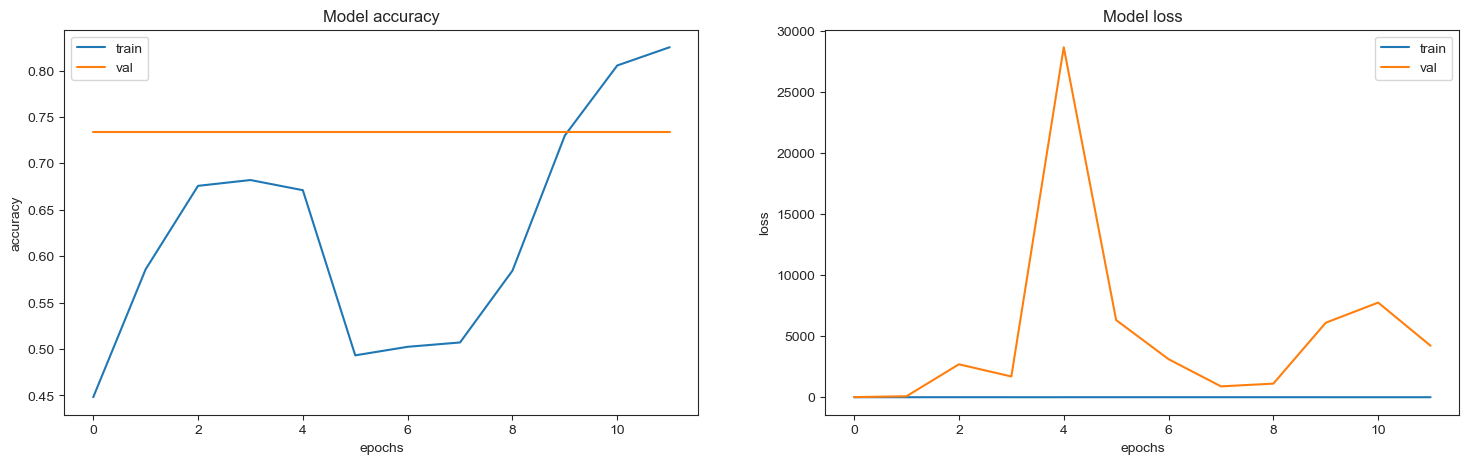

In [48]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history3.history[element])
    axis[i].plot(history3.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

### Predict and Evaluate on test dataset

In [50]:
eval_result3 = model3.evaluate(test_generator)
print('loss rate at evaluation data :', eval_result3[0])
print('accuracy rate at evaluation data :', eval_result3[1])

5/5 [==============================] - 41s 8s/step - loss: 5999.5615 - accuracy: 0.6250
loss rate at evaluation data : 5999.5615234375
accuracy rate at evaluation data : 0.625


Below code helps us find the list of images on which prediction is wrong as well as list of images on which prediction is correct.

In [51]:
Residual_model = model3

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 128 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = Residual_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
#         print(len(correct_predicted_image[0]),len(wrong_predicted_image[0]))
        j += 1
        
    i += 1

1/1 [==============================] - 0s 98ms/step
